In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cow_data.xls to cow_data (2).xls


In [ ]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
!pip install dataframe-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 2.3 MB/s 


In [ ]:
import pandas as pd
import io
df = pd.read_excel(io.BytesIO(uploaded['cow_data.xls']))

df.head()

,CowID,PARTI,DIM,ProblemsDry,ProblemsPeripartum,Prob1month,Prob2months,Milk_yield,milkfat,milkprotein,...,PCV,NEFA,chol,LDL,HDL,PL,GH,paraox,Insul,Insulres
0,329,PL,-14,0,1,1,0,.,.,.,...,.,.,NaN,.,.,.,.,NaN,NaN,NaN
1,329,PL,-7,0,1,1,0,.,.,.,...,0.35,0.24,2.34192,0.44,1.07,55.25,4.71,53.253846,6.93,NaN
2,329,PL,-3,0,1,1,0,.,.,.,...,0.35,0.24,2.34192,0.44,1.07,55.25,4.71,53.253846,NaN,NaN
3,329,PL,0,0,1,1,0,.,.,.,...,0.37,0.7,2.08488,0.36,0.8,33.11,9.48,48.138462,3.63,1.126107
4,329,PL,7,0,1,1,0,25,4.83,3.92,...,0.3,0.39,1.98968,0.37,0.98,53.86,9.85,46.533846,3.09,0.479293


In [ ]:
# Required Packages 
import numpy as np
from sklearn.preprocessing import OneHotEncoder 

#One hot Encoder
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(df[['PARTI']]).toarray()
df.drop(["PARTI"], axis=1, inplace=True)
feature_labels = ohe.categories_
feature_labels = np.array(feature_labels).ravel()

#Re-create DataFrame
features = pd.DataFrame(feature_arr, columns= ['PARTI_PL', 'PARTI_PR'] ,index= df.index)


In [ ]:
#Join with original dataset (we've dropped original PART)
df_v1= features.join(df, how='outer')
df_v1 = df_v1.replace('.', np.nan)


In [ ]:
# forgoe for the moment, and gather a series of columns where it makes sense to have stats 
# [ DIM, ]
df_v1.groupby('CowID').describe()
#DIM has the same average for all, same values 
df_v1.groupby('CowID').mean()
#DIM --suggestion: remove
df_v1 = df_v1.drop('DIM', axis=1)


In [ ]:
#Problem_Dry can become aggregate ---suggestion: keep
df_v1.groupby('CowID')['ProblemsDry'].sum()
temp_data= df_v1.groupby('CowID')['ProblemsDry'].sum().reset_index()


In [ ]:
#can become aggregate ---suggestion: keep
pp= df_v1.groupby('CowID')['ProblemsPeripartum'].sum().reset_index()
temp_data= pd.merge( temp_data,pp, on='CowID')
temp_data.head()

,CowID,ProblemsDry,ProblemsPeripartum
0,6,0,13
1,12,0,0
2,14,0,13
3,21,0,13
4,38,13,13


In [ ]:
#can become aggregate ---suggestion: keep
p1m= df_v1.groupby('CowID')['Prob1month'].sum().reset_index()
temp_data= pd.merge( temp_data,p1m, on='CowID')
temp_data.head()

,CowID,ProblemsDry,ProblemsPeripartum,Prob1month
0,6,0,13,13
1,12,0,0,0
2,14,0,13,26
3,21,0,13,13
4,38,13,13,0


In [ ]:
#can become aggregate ---suggestion: keep
p2m= df_v1.groupby('CowID')['Prob2months'].sum().reset_index()
temp_data= pd.merge( temp_data,p2m, on='CowID')
temp_data.head()

,CowID,ProblemsDry,ProblemsPeripartum,Prob1month,Prob2months
0,6,0,13,13,0
1,12,0,0,0,0
2,14,0,13,26,0
3,21,0,13,13,13
4,38,13,13,0,0


In [ ]:
#Adding PARTI_PL 
temp_a= df_v1[['CowID','PARTI_PL','PARTI_PR']].drop_duplicates()
temp_data= pd.merge( temp_a,temp_data,on='CowID')

In [ ]:
#Adding Sick to temp_data
kw= [12,58,86,117,211,224,3409,3427,4244,4806, 4836]
df_v1['Sick']=~df_v1['CowID'].isin(kw)

temp_b= df_v1[['CowID','Sick']].drop_duplicates()
temp_data= pd.merge( temp_b,temp_data,on='CowID')
temp_data.head()

,CowID,Sick,PARTI_PL,PARTI_PR,ProblemsDry,ProblemsPeripartum,Prob1month,Prob2months
0,329,True,1.0,0.0,0,13,13,0
1,340,True,0.0,1.0,0,13,13,0
2,1107,True,1.0,0.0,0,13,26,0
3,116,True,0.0,1.0,0,0,0,0
4,117,False,0.0,1.0,13,13,0,0


Given that we time measurements in time, with an important even (parturition) in the middle, the plan has been that to aggregate the majority of the data in pre and post variables. Further more, the metric of choice to deterine the variation between different measruement in each interval has been the IQR; this one is not influence by outliers, and provides a good idea about the variation between different times for the same observation/predictor. 




count    88.000000
mean     30.850000
std       8.893405
min      18.000000
25%      23.000000
50%      29.500000
75%      38.250000
max      53.000000
Name: Milk_yield, dtype: float64
IQR:  15.25


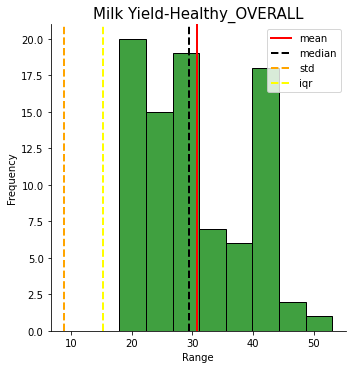

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

import dataframe_image as dfi
#Basic numerical summary

#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['Milk_yield'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.75)
desc.loc["IQR",'Milk_yield']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_Milk_Yield_Healthy_OVERALL.png")

print(df_v1[df_v1['Sick'] == False]['Milk_yield'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['Milk_yield'],color='green')
plt.title("Milk Yield-Healthy_OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['Milk_yield'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['Milk_yield'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['Milk_yield'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('Milk_Yield_Healthy_OVERALL.png',bbox_inches='tight')

count    221.000000
mean      25.808145
std        8.507143
min        4.000000
25%       20.000000
50%       24.000000
75%       32.000000
max       46.000000
Name: Milk_yield, dtype: float64
IQR:  12.0


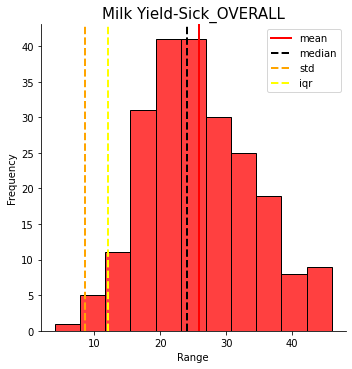

In [ ]:
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['Milk_yield'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.75)
desc.loc["IQR",'Milk_yield']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_Milk_Yield_Sick_OVERALL.png")

print(df_v1[df_v1['Sick'] == True]['Milk_yield'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['Milk_yield'],color='red')
plt.title("Milk Yield-Sick_OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['Milk_yield'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['Milk_yield'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['Milk_yield'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('Milk_Yield_Sick_OVERALL.png',bbox_inches='tight')

In [ ]:
#In this section we brake milk yield (and all other milk factors) into PRE & POST
# this is an attempt to differentiate between cows that might eventually become sick
# and those that will be well. A cow that develops some kind of sickness, is probably 
# already starting at a disadvantage (assumption). 

#ITerate over the dataset, (iterate over the element of each COW ID)
# remove the first 4 numbers, add them to new colum in same position, finish
df_v1['milk_yield_pre']=np.nan
df_v1['milkfat_pre']=np.nan
df_v1['milkprotein_pre']=np.nan
df_v1['milklactose_pre']=np.nan
df_v1['SCC_pre']=np.nan



ids= df_v1['CowID'].drop_duplicates().to_list()
ids= sorted(ids)
#Iterate over each id, and iterate over all elements of each ID. 
for y in ids:
        #Subset of all prodcuts having id == y
        observation= df_v1[df_v1['CowID']==y]

        flag=0
        #Iterate over each measurement of each cow
        for index, row in observation.iterrows():
          #skip over nulls ( we know there are 9 measurements per cow; hence PRE (first 4 measurements))
          if(pd.isna (row['Milk_yield'] )):
            continue 
          else:
            #Delete this and put this into the new row  
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['Milk_yield'] == row['Milk_yield']), "milk_yield_pre"] = row['Milk_yield']
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['milkfat'] == row['milkfat']), "milkfat_pre"] = row['milkfat']
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['milkprotein'] == row['milkprotein']), "milkprotein_pre"] = row['milkprotein']
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['milklactose'] == row['milklactose']), "milklactose_pre"] = row['milklactose']
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['SCC'] == row['SCC']), "SCC_pre"] = row['SCC']



            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['Milk_yield'] == row['Milk_yield']), "Milk_yield"] = np.nan
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['milkfat'] == row['milkfat']), "milkfat"] = np.nan
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['milkprotein'] == row['milkprotein']), "milkprotein"] = np.nan
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['milklactose'] == row['milklactose']), "milklactose"] = np.nan
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['SCC'] == row['SCC']), "SCC"] = np.nan


      
            flag+=1
            if(flag==4):
              flag=0
              break

count    37.000000
mean     33.821622
std       8.484598
min      22.000000
25%      26.400000
50%      30.000000
75%      42.000000
max      53.000000
Name: Milk_yield, dtype: float64
IQR:  15.600000000000001


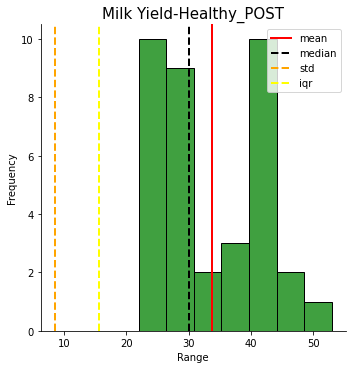

In [ ]:
#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['Milk_yield'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.75)
desc.loc["IQR",'Milk_yield']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_Milk_Yield_Healthy_POST.png")

print(df_v1[df_v1['Sick'] == False]['Milk_yield'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['Milk_yield'],color='green')
plt.title("Milk Yield-Healthy_POST", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['Milk_yield'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['Milk_yield'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['Milk_yield'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['Milk_yield'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('Milk_Yield_Healthy_POST.png',bbox_inches='tight')

count    94.000000
mean     29.865957
std       7.434380
min      16.000000
25%      24.000000
50%      30.000000
75%      34.000000
max      46.000000
Name: Milk_yield, dtype: float64
IQR:  10.0


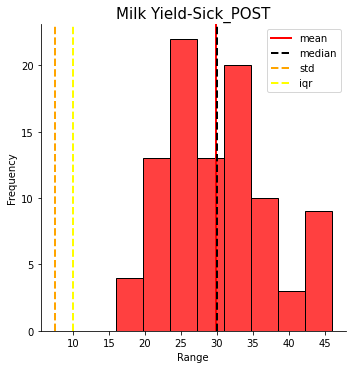

In [ ]:
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['Milk_yield'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.75)
desc.loc["IQR",'Milk_yield']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_Milk_Yield_Sick_POST.png")

print(df_v1[df_v1['Sick'] == True]['Milk_yield'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['Milk_yield'],color='red')
plt.title("Milk Yield-Sick_POST", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['Milk_yield'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['Milk_yield'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['Milk_yield'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['Milk_yield'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)
plt.legend()

#Save
plt.savefig('Milk_Yield_Sick_POST.png',bbox_inches='tight')

count    51.000000
mean     28.694118
std       8.632159
min      18.000000
25%      21.500000
50%      28.000000
75%      34.000000
max      44.000000
Name: milk_yield_pre, dtype: float64
IQR:  12.5


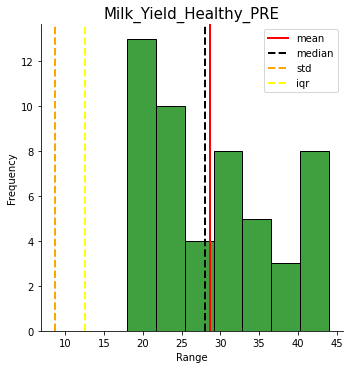

In [ ]:
#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['milk_yield_pre'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['milk_yield_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['milk_yield_pre'].quantile(0.75)
desc.loc["IQR",'milk_yield_pre']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_Milk_Yield_Healthy_PRE.png")

print(df_v1[df_v1['Sick'] == False]['milk_yield_pre'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['milk_yield_pre'],color='green')
plt.title("Milk_Yield_Healthy_PRE", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['milk_yield_pre'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['milk_yield_pre'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['milk_yield_pre'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['milk_yield_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['milk_yield_pre'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)
plt.legend()

#Save
plt.savefig('Milk_Yield_Healthy_PRE.png',bbox_inches='tight')

count    127.000000
mean      22.804724
std        8.012003
min        4.000000
25%       18.000000
50%       21.000000
75%       28.000000
max       42.000000
Name: milk_yield_pre, dtype: float64
IQR:  10.0


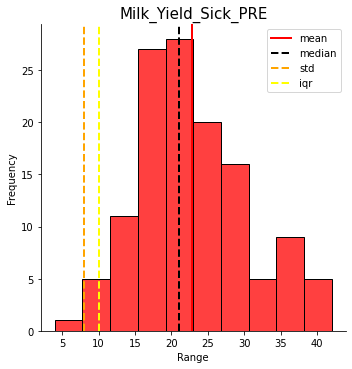

In [ ]:
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['milk_yield_pre'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['milk_yield_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['milk_yield_pre'].quantile(0.75)
desc.loc["IQR",'milk_yield_pre']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_Milk_Yield_Sick_PRE.png")

print(df_v1[df_v1['Sick'] == True]['milk_yield_pre'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['milk_yield_pre'],color='red')
plt.title("Milk_Yield_Sick_PRE", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['milk_yield_pre'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['milk_yield_pre'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['milk_yield_pre'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['milk_yield_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['milk_yield_pre'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)
plt.legend()

#Save
plt.savefig('Milk_Yield_Sick_PRE.png',bbox_inches='tight')

In [ ]:
#Creating IQR ranges for PRE and POST (iqr was the metric chosen given it is resistant to outliers/extremes)
from scipy import stats
from scipy.stats import iqr

# Interquartile range (IQR)
t1 =df_v1[df_v1['Milk_yield'].notna()].groupby('CowID')['Milk_yield'].agg(iqr).to_frame().rename(columns={"Milk_yield": "milk_yiled_IQR_post"})
temp_data=temp_data.merge(t1,how='outer',on='CowID')

t2 =df_v1[df_v1['milk_yield_pre'].notna()].groupby('CowID')['milk_yield_pre'].agg(iqr).to_frame().rename(columns={"milk_yield_pre": "milk_yiled_IQR_pre"})
temp_data=temp_data.merge(t2,how='outer',on='CowID')

t3 =df_v1[df_v1['milkfat'].notna()].groupby('CowID')['milkfat'].agg(iqr).to_frame().rename(columns={"milkfat": "milkfat_IQR_post"})
temp_data=temp_data.merge(t3,how='outer',on='CowID')

t4 =df_v1[df_v1['milkfat_pre'].notna()].groupby('CowID')['milkfat_pre'].agg(iqr).to_frame().rename(columns={"milkfat_pre": "milkfat_IQR_pre"})
temp_data=temp_data.merge(t4,how='outer',on='CowID')

t5 =df_v1[df_v1['milkprotein'].notna()].groupby('CowID')['milkprotein'].agg(iqr).to_frame().rename(columns={"milkprotein": "milkprotein_IQR_post"})
temp_data=temp_data.merge(t5,how='outer',on='CowID')

t6 =df_v1[df_v1['milkprotein_pre'].notna()].groupby('CowID')['milkprotein_pre'].agg(iqr).to_frame().rename(columns={"milkprotein_pre": "milkprotein_IQR_pre"})
temp_data=temp_data.merge(t6,how='outer',on='CowID')

t7 =df_v1[df_v1['milklactose'].notna()].groupby('CowID')['milklactose'].agg(iqr).to_frame().rename(columns={"milklactose": "milklactose_IQR_post"})
temp_data=temp_data.merge(t7,how='outer',on='CowID')

t8 =df_v1[df_v1['milklactose_pre'].notna()].groupby('CowID')['milklactose_pre'].agg(iqr).to_frame().rename(columns={"milklactose_pre": "milklactose_IQR_pre"})
temp_data=temp_data.merge(t8,how='outer',on='CowID')

t9 =df_v1[df_v1['SCC'].notna()].groupby('CowID')['SCC'].agg(iqr).to_frame().rename(columns={"SCC": "SCC_IQR_post"})
temp_data=temp_data.merge(t9,how='outer',on='CowID')

t10 =df_v1[df_v1['SCC_pre'].notna()].groupby('CowID')['SCC_pre'].agg(iqr).to_frame().rename(columns={"SCC_pre": "SCC_IQR_pre"})
temp_data=temp_data.merge(t10,how='outer',on='CowID')

In [ ]:
temp_data.head()

,CowID,Sick,PARTI_PL,PARTI_PR,ProblemsDry,ProblemsPeripartum,Prob1month,Prob2months,milk_yiled_IQR_post,milk_yiled_IQR_pre,milkfat_IQR_post,milkfat_IQR_pre,milkprotein_IQR_post,milkprotein_IQR_pre,milklactose_IQR_post,milklactose_IQR_pre,SCC_IQR_post,SCC_IQR_pre
0,329,True,1.0,0.0,0,13,13,0,6.0,2.50,0.90,0.7725,0.10,0.4325,0.2000,0.1475,2.701919,1.424630
1,340,True,0.0,1.0,0,13,13,0,8.0,2.25,0.17,0.3200,0.14,0.3200,0.2300,0.4200,1.201634,2.090007
2,1107,True,1.0,0.0,0,13,26,0,5.0,4.75,0.15,0.4350,0.06,0.1400,0.1200,0.4250,1.160964,1.745859
3,116,True,0.0,1.0,0,0,0,0,NaN,10.00,0.00,0.5225,0.00,0.1900,0.0000,0.1950,0.000000,3.281861
4,117,False,0.0,1.0,13,13,0,0,0.0,1.50,0.72,0.2975,0.21,0.1950,0.1625,0.2200,0.633652,1.610736


count    207.000000
mean       2.489855
std        0.431714
min        1.700000
25%        2.125000
50%        2.500000
75%        2.800000
max        3.500000
Name: BCS, dtype: float64
IQR:  0.6749999999999998


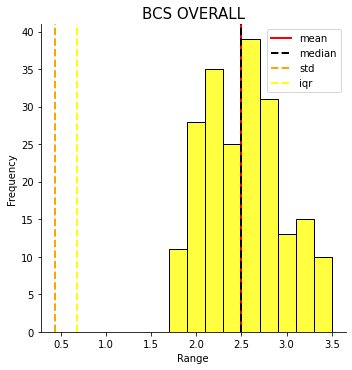

In [ ]:
#BCS
#Table statistics 
desc=df_v1['BCS'].describe().to_frame()
q1 = df_v1['BCS'].quantile(0.25)
q3 = df_v1['BCS'].quantile(0.75)
desc.loc["IQR",'BCS']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1['BCS'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1['BCS'],color='yellow')
plt.title("BCS OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1['BCS'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1['BCS'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1['BCS'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1['BCS'].quantile(0.25)
q3 = df_v1['BCS'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('BCS_Healthy_OVERALL.png',bbox_inches='tight')

count    65.000000
mean      2.561538
std       0.404638
min       1.800000
25%       2.300000
50%       2.500000
75%       2.800000
max       3.500000
Name: BCS, dtype: float64
IQR:  0.5


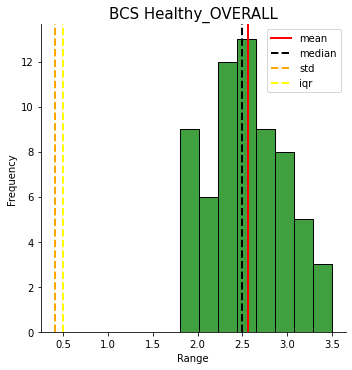

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['BCS'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.75)
desc.loc["IQR",'BCS']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1[df_v1['Sick'] == False]['BCS'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['BCS'],color='green')
plt.title("BCS Healthy_OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('BCS_Healthy_OVERALL.png',bbox_inches='tight')

count    148.000000
mean       2.461149
std        0.433614
min        1.700000
25%        2.100000
50%        2.500000
75%        2.800000
max        3.500000
Name: BCS, dtype: float64
IQR:  0.6999999999999997


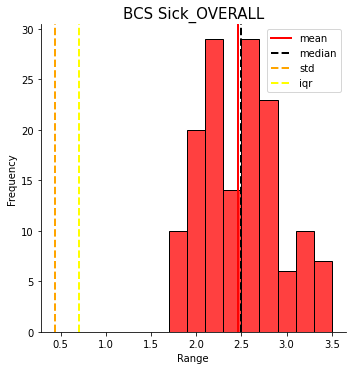

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['BCS'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.75)
desc.loc["IQR",'BCS']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Sick_OVERALL.png")

print(df_v1[df_v1['Sick'] == True]['BCS'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['BCS'],color='red')
plt.title("BCS Sick_OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('BCS_Sick_OVERALL.png',bbox_inches='tight')

In [ ]:

#ITerate over the dataset, (iterate over the element of each COW ID)
# remove the first 3 numbers, add them to new colum in same position, finish
df_v1['BCS_pre']=np.nan

ids= df_v1['CowID'].drop_duplicates().to_list()
ids= sorted(ids)
#Iterate over each id, and iterate over all elements of each ID. 
for y in ids:
        #Subset of all prodcuts having id == y
        observation= df_v1[df_v1['CowID']==y]

        flag=0
        #Iterate over each measurement of each cow
        for index, row in observation.iterrows():
          #skip over nulls ( we know there are 9 measurements per cow; hence PRE (first 4 measurements))
          if(pd.isna (row['BCS'] )):
            continue 
          else:
            #Delete this and put this into the new row  
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['BCS'] == row['BCS']), "BCS_pre"] = row['BCS']
            df_v1.loc[ (df_v1['CowID'] == row['CowID']) & (df_v1['BCS'] == row['BCS']), "BCS"] = np.nan
                  
            flag+=1
            if(flag==3):
              flag=0
              break

count    29.000000
mean      2.331034
std       0.332580
min       1.800000
25%       2.000000
50%       2.400000
75%       2.500000
max       3.100000
Name: BCS, dtype: float64
IQR:  0.5


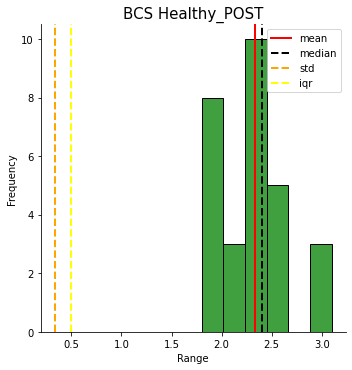

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['BCS'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.75)
desc.loc["IQR",'BCS']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1[df_v1['Sick'] == False]['BCS'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['BCS'],color='green')
plt.title("BCS Healthy_POST", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['BCS'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('BCS_Healthy_POST.png',bbox_inches='tight')

count    64.000000
mean      2.253906
std       0.357050
min       1.700000
25%       2.000000
50%       2.200000
75%       2.500000
max       3.300000
Name: BCS, dtype: float64
IQR:  0.5


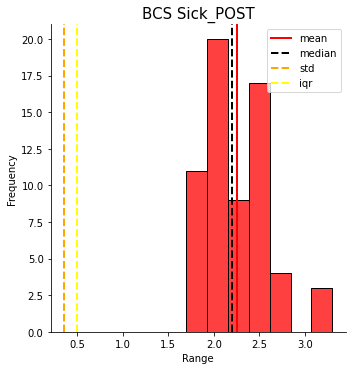

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['BCS'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.75)
desc.loc["IQR",'BCS']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Sick_OVERALL.png")

print(df_v1[df_v1['Sick'] == True]['BCS'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['BCS'],color='red')
plt.title("BCS Sick_POST", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['BCS'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('BCS_Sick_POST.png',bbox_inches='tight')

count    30.000000
mean      2.785000
std       0.380143
min       2.000000
25%       2.562500
50%       2.775000
75%       3.000000
max       3.500000
Name: BCS_pre, dtype: float64
IQR:  0.4375


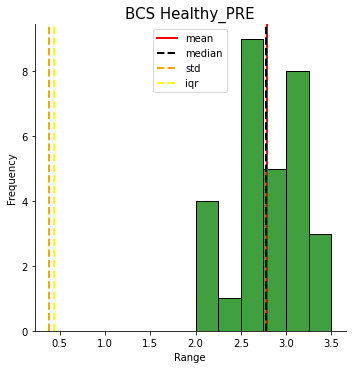

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['BCS_pre'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['BCS_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['BCS_pre'].quantile(0.75)
desc.loc["IQR",'BCS_pre']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1[df_v1['Sick'] == False]['BCS_pre'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['BCS_pre'],color='green')
plt.title("BCS Healthy_PRE", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS_pre'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS_pre'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['BCS_pre'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['BCS_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['BCS_pre'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('BCS_Healthy_PRE.png',bbox_inches='tight')

count    84.000000
mean      2.619048
std       0.421765
min       1.800000
25%       2.200000
50%       2.600000
75%       2.900000
max       3.500000
Name: BCS_pre, dtype: float64
IQR:  0.6999999999999997


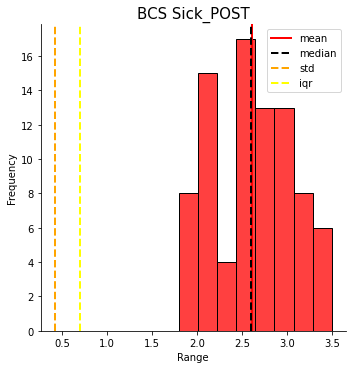

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['BCS_pre'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['BCS_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['BCS_pre'].quantile(0.75)
desc.loc["IQR",'BCS_pre']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Sick_OVERALL.png")

print(df_v1[df_v1['Sick'] == True]['BCS_pre'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['BCS_pre'],color='red')
plt.title("BCS Sick_POST", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS_pre'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS_pre'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['BCS_pre'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['BCS_pre'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['BCS_pre'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
plt.savefig('BCS_Sick_POST.png',bbox_inches='tight')

count    175.000000
mean       1.469486
std        0.353827
min        0.380000
25%        1.280000
50%        1.460000
75%        1.665000
max        3.610000
Name: Lisoz, dtype: float64
IQR:  0.385


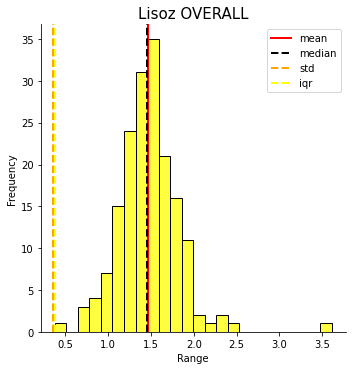

In [ ]:
#Lisoz
#Table statistics 
desc=df_v1['Lisoz'].describe().to_frame()
q1 = df_v1['Lisoz'].quantile(0.25)
q3 = df_v1['Lisoz'].quantile(0.75)
desc.loc["IQR",'Lisoz']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1['Lisoz'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1['Lisoz'],color='yellow')
plt.title("Lisoz OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1['Lisoz'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1['Lisoz'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1['Lisoz'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1['Lisoz'].quantile(0.25)
q3 = df_v1['Lisoz'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('Lisoz_Healthy_OVERALL.png',bbox_inches='tight')

count    51.000000
mean      1.382353
std       0.330179
min       0.380000
25%       1.170000
50%       1.440000
75%       1.555000
max       2.150000
Name: Lisoz, dtype: float64
IQR:  0.38500000000000023


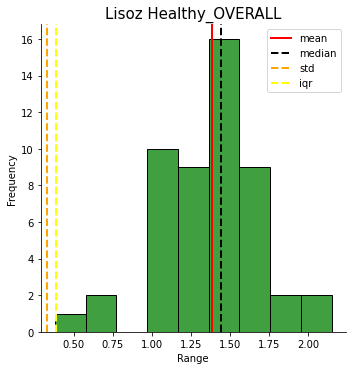

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == False]['Lisoz'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == False]['Lisoz'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['Lisoz'].quantile(0.75)
desc.loc["IQR",'Lisoz']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1[df_v1['Sick'] == False]['Lisoz'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == False]['Lisoz'],color='green')
plt.title("Lisoz Healthy_OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == False]['Lisoz'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['Lisoz'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == False]['Lisoz'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == False]['Lisoz'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == False]['Lisoz'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('Lisoz_Healthy_OVERALL.png',bbox_inches='tight')

count    124.000000
mean       1.505323
std        0.358251
min        0.710000
25%        1.297500
50%        1.475000
75%        1.702500
max        3.610000
Name: Lisoz, dtype: float64
IQR:  0.4049999999999998


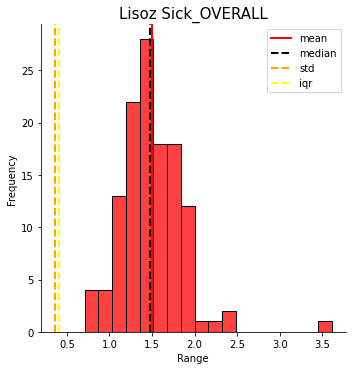

In [ ]:
#BCS
#Table statistics 
desc=df_v1[df_v1['Sick'] == True]['Lisoz'].describe().to_frame()
q1 = df_v1[df_v1['Sick'] == True]['Lisoz'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['Lisoz'].quantile(0.75)
desc.loc["IQR",'Lisoz']= q3-q1
df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(df_v1[df_v1['Sick'] == True]['Lisoz'].describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(df_v1[df_v1['Sick'] == True]['Lisoz'],color='red')
plt.title("Lisoz Sick_OVERALL", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(df_v1[df_v1['Sick'] == True]['Lisoz'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['Lisoz'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(df_v1[df_v1['Sick'] == True]['Lisoz'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = df_v1[df_v1['Sick'] == True]['Lisoz'].quantile(0.25)
q3 = df_v1[df_v1['Sick'] == True]['Lisoz'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('Lisoz_Sick_OVERALL.png',bbox_inches='tight')

In [ ]:
t13= df_v1[df_v1['Lisoz'].notna()].groupby('CowID')['Lisoz'].agg(iqr).to_frame().rename(columns={"Lisoz": "Lisoz_IQR"})
temp_data=temp_data.merge(t13,how='outer',on='CowID')

t14= df_v1[df_v1['NOx'].notna()].groupby('CowID')['NOx'].agg(iqr).to_frame().rename(columns={"NOx": "NOx_IQR"})
temp_data=temp_data.merge(t14,how='outer',on='CowID')

t15= df_v1[df_v1['NO2'].notna()].groupby('CowID')['NO2'].agg(iqr).to_frame().rename(columns={"NO2": "NO2_IQR"})
temp_data=temp_data.merge(t15,how='outer',on='CowID')

t16= df_v1[df_v1['NO3'].notna()].groupby('CowID')['NO3'].agg(iqr).to_frame().rename(columns={"NO3": "NO3_IQR"})
temp_data=temp_data.merge(t16,how='outer',on='CowID')

t17= df_v1[df_v1['ROMtot'].notna()].groupby('CowID')['ROMtot'].agg(iqr).to_frame().rename(columns={"ROMtot": "ROMtot_IQR"})
temp_data=temp_data.merge(t17,how='outer',on='CowID')

t18= df_v1[df_v1['ROMsep'].notna()].groupby('CowID')['ROMsep'].agg(iqr).to_frame().rename(columns={"ROMsep": "ROMsep_IQR"})
temp_data=temp_data.merge(t18,how='outer',on='CowID')

t19= df_v1[df_v1['ROMseptTot'].notna()].groupby('CowID')['ROMseptTot'].agg(iqr).to_frame().rename(columns={"ROMseptTot": "ROMseptTot_IQR"})
temp_data=temp_data.merge(t19,how='outer',on='CowID')

t20= df_v1[df_v1['oxyat'].notna()].groupby('CowID')['oxyat'].agg(iqr).to_frame().rename(columns={"oxyat": "oxyat_IQR"})
temp_data=temp_data.merge(t20,how='outer',on='CowID')

t21= df_v1[df_v1['oxyrom'].notna()].groupby('CowID')['oxyrom'].agg(iqr).to_frame().rename(columns={"oxyrom": "oxyrom_IQR"})
temp_data=temp_data.merge(t21,how='outer',on='CowID')

t22= df_v1[df_v1['VitEROM'].notna()].groupby('CowID')['VitEROM'].agg(iqr).to_frame().rename(columns={"VitEROM": "VitEROM_IQR"})
temp_data=temp_data.merge(t22,how='outer',on='CowID')

temp_data

,CowID,Sick,PARTI_PL,PARTI_PR,ProblemsDry,ProblemsPeripartum,Prob1month,Prob2months,milk_yiled_IQR_post,milk_yiled_IQR_pre,...,Lisoz_IQR,NOx_IQR,NO2_IQR,NO3_IQR,ROMtot_IQR,ROMsep_IQR,ROMseptTot_IQR,oxyat_IQR,oxyrom_IQR,VitEROM_IQR
0,329,True,1.0,0.0,0,13,13,0,6.00,2.50,...,0.26,15.7500,0.1600,15.9100,0.920,0.6300,1.290000,37.70,3.780,0.4900
1,340,True,0.0,1.0,0,13,13,0,8.00,2.25,...,0.64,6.7300,0.7900,7.4000,4.650,4.6200,6.166329,27.59,2.120,5.7600
2,1107,True,1.0,0.0,0,13,26,0,5.00,4.75,...,0.46,6.5200,0.6200,5.6000,4.210,1.3300,5.499220,44.90,2.350,2.5100
3,116,True,0.0,1.0,0,0,0,0,NaN,10.00,...,0.13,13.9000,1.3600,15.8800,2.330,2.4200,8.426088,5.93,2.780,2.2500
4,117,False,0.0,1.0,13,13,0,0,0.00,1.50,...,0.23,42.8900,1.2400,42.5100,1.110,2.2700,7.007098,22.06,1.040,1.1800
5,12,False,1.0,0.0,0,0,0,0,0.00,5.90,...,0.32,5.1600,1.5700,3.0600,1.730,0.4300,3.130000,28.19,0.580,16.6700
6,211,False,1.0,0.0,0,0,13,0,0.00,10.00,...,0.08,22.0100,1.2600,20.0000,5.520,4.5300,3.260000,27.34,4.560,6.6600
7,2208,True,1.0,0.0,0,0,13,0,1.00,6.00,...,0.42,14.3700,1.6500,13.1100,0.510,0.9000,2.550000,33.77,2.830,5.5700
8,222,True,1.0,0.0,0,13,26,0,2.00,8.00,...,0.15,17.3000,0.5500,14.6100,1.150,1.1100,11.760779,48.84,0.940,1.1400
9,224,False,1.0,0.0,0,0,0,0,4.00,2.00,...,0.10,12.0000,0.1000,12.1800,1.340,0.6600,1.140000,19.92,1.660,3.6600


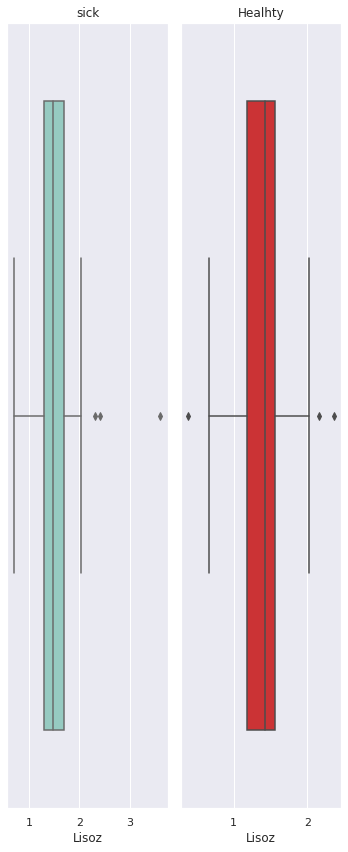

In [ ]:
#Plot
import seaborn as sns
fig,axes = plt.subplots(1,2)
sns.boxplot(x=zelig1['Lisoz'], color='red',ax=axes[0],palette="Set3")
axes[0].set_title('sick')
sns.boxplot(x=zelig2['Lisoz'],color='green',ax=axes[1],palette="Set1")
axes[1].set_title('Healhty')

fig.tight_layout()
sns.set(rc={'figure.figsize':(12,5)})

plt.show() 


/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


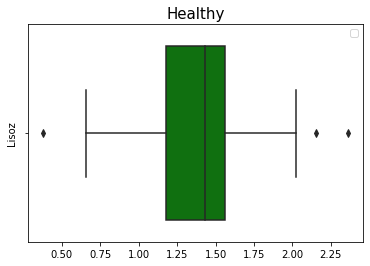

In [ ]:
#Plot
import seaborn as sns


           Lisoz
count  24.000000
mean    1.472917
std     0.202624
min     1.080000
25%     1.365000
50%     1.465000
75%     1.630000
max     1.920000
IQR:  Lisoz    0.265
dtype: float64


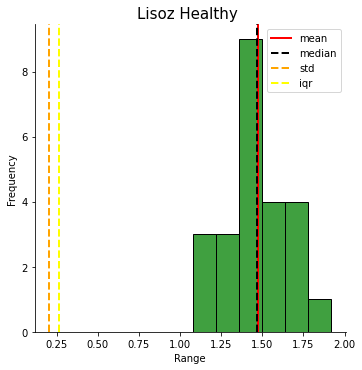

In [ ]:
#Table statistics 
q1 = t11.quantile(0.25)
q3 = t11.quantile(0.75)
#df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(t11.describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(t11['Lisoz'],color='green')
plt.title("Lisoz Healthy ", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(t11['Lisoz'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(t11['Lisoz'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(t11['Lisoz'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = t11['Lisoz'].quantile(0.25)
q3 = t11['Lisoz'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('Lisoz_Sick_OVERALL.png',bbox_inches='tight')

           Lisoz
count  11.000000
mean    1.349091
std     0.306217
min     0.670000
25%     1.200000
50%     1.420000
75%     1.490000
max     1.870000
IQR:  Lisoz    0.29
dtype: float64


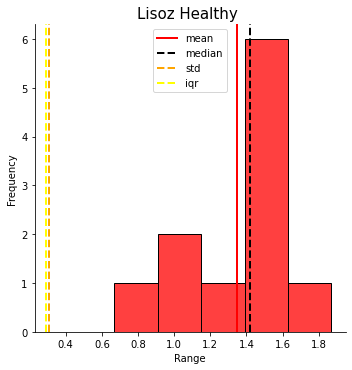

In [ ]:
#Table statistics 
q1 = t12.quantile(0.25)
q3 = t12.quantile(0.75)
#df_styled = desc.style.background_gradient()
#dfi.export(df_styled, "summary_BSC_Healthy_OVERALL.png")

print(t12.describe())
print("IQR: ",q3-q1)

#create histogram
sns.displot(t12['Lisoz'],color='red')
plt.title("Lisoz Healthy ", fontsize = 15)
plt.xlabel("Range")
plt.ylabel("Frequency")
plt.axvline(t12['Lisoz'].mean(), color='red', label='mean', linewidth=2)
plt.axvline(t12['Lisoz'].median(), color='black', label='median', linestyle= 'dashed',linewidth=2)
plt.axvline(t12['Lisoz'].std(), color='orange', label='std', linestyle= 'dashed',linewidth=2)
q1 = t12['Lisoz'].quantile(0.25)
q3 = t12['Lisoz'].quantile(0.75)
plt.axvline(q3-q1, color='yellow', label='iqr', linestyle= 'dashed',linewidth=2)

#Save
plt.legend()
#plt.savefig('Lisoz_Sick_OVERALL.png',bbox_inches='tight')

In [ ]:
#Take variables in considerations (last 3 problemati~ skip for the moment being) 
#Remove nans
#Loop over each id
# count total obs /2 
# create pre/post 
columns= ['VitE', 'VitA','Albumin', 'Protein', 'Globulin', 'Bilirubin', 'Creatinine', 'Glucose', 'Triglicerides', 'urea', 'ca', 'Mg', 'P', 'Ceruloplasmin', 'ALP', 'GOT',
       'GGT', 'BHBA', 'Haptoglobin', 'Na', 'K', 'Cl', 'PCV', 'NEFA', 'chol', 'LDL', 'HDL', 'PL', 'GH', 'paraox']
last= df_v1[['CowID', 'VitE', 'VitA',
       'Albumin', 'Protein', 'Globulin', 'Bilirubin', 'Creatinine', 'Glucose',
       'Triglicerides', 'urea', 'ca', 'Mg', 'P', 'Ceruloplasmin', 'ALP', 'GOT',
       'GGT', 'BHBA', 'Haptoglobin', 'Na', 'K', 'Cl', 'PCV', 'NEFA', 'chol',
       'LDL', 'HDL', 'PL', 'GH']]
last= last.dropna()

#for c in columns:
for c in columns:

  list_pre_iqr = []
  list_post_iqr = [] 
  for y in ids:
          #Subset of all prodcuts having id == y
          observation= last[last['CowID']==y]
          counter= int(len(last[last['CowID']==y])/2)
          pre_list= []
          post_list= []

          #Iterate over each measurement of each cow
          for index, row in observation.iterrows():
            #Pre
            if(counter>0):
              pre_list.append(row[c])
              counter-=1 
            elif(counter==0):
              #sort
              pre_list= sorted(pre_list)
              #compute IQR 
              q3, q1 = np.percentile(pre_list, [75 ,25])
              iqr = q3 - q1
              list_pre_iqr.append(iqr)
              counter=-10000
            #post
            else:
              post_list.append(row[c])
          post_list= sorted(post_list)

          q3, q1 = np.percentile(post_list, [75 ,25])
          iqr = q3 - q1
          list_post_iqr.append(iqr)

  goz= pd.DataFrame(list(zip(ids,list_pre_iqr, list_post_iqr)), columns =['CowID',c+'_IQR_PRE', c+'_IQR_POST']) 
  #Add to temp_data_frame
  temp_data=temp_data.merge(goz,how='outer',on='CowID')
temp_data

,CowID,Sick,PARTI_PL,PARTI_PR,ProblemsDry,ProblemsPeripartum,Prob1month,Prob2months,milk_yiled_IQR_post,milk_yiled_IQR_pre,...,chol_IQR_PRE,chol_IQR_POST,LDL_IQR_PRE,LDL_IQR_POST,HDL_IQR_PRE,HDL_IQR_POST,PL_IQR_PRE,PL_IQR_POST,GH_IQR_PRE,GH_IQR_POST
0,329,True,1.0,0.0,0,13,13,0,6.00,2.50,...,0.24276,0.20944,0.0775,0.2700,0.0825,0.5900,2.4750,28.1600,3.7700,0.7200
1,340,True,0.0,1.0,0,13,13,0,8.00,2.25,...,0.57358,1.18048,0.1975,0.0800,0.1525,0.0100,12.0975,22.1500,4.3725,4.8200
2,1107,True,1.0,0.0,0,13,26,0,5.00,4.75,...,0.38080,0.85680,0.1175,0.1800,0.3050,0.6100,16.8025,4.0900,5.6025,4.2200
3,116,True,0.0,1.0,0,0,0,0,NaN,10.00,...,0.12852,0.66640,0.0450,0.0750,0.0800,0.1200,2.0050,13.5350,14.8750,2.7650
4,117,False,0.0,1.0,13,13,0,0,0.00,1.50,...,0.35224,0.20944,0.0625,0.0400,0.0600,0.0400,27.4900,12.0200,2.7175,2.0200
5,12,False,1.0,0.0,0,0,0,0,0.00,5.90,...,0.07140,0.86870,0.1425,0.1825,0.0675,0.5850,6.7450,24.8600,12.8200,1.1950
6,211,False,1.0,0.0,0,0,13,0,0.00,10.00,...,0.39508,0.49504,0.0400,0.1275,0.2475,0.4325,20.7550,21.2400,10.6550,1.5250
7,2208,True,1.0,0.0,0,0,13,0,1.00,6.00,...,0.87822,0.96152,0.0700,0.2000,0.2400,0.4100,11.7475,17.0100,3.1925,7.4000
8,222,True,1.0,0.0,0,13,26,0,2.00,8.00,...,0.12376,0.90440,0.3200,0.0700,0.5200,0.2900,10.3600,6.9000,6.3300,2.6000
9,224,False,1.0,0.0,0,0,0,0,4.00,2.00,...,0.11424,0.08568,0.1400,0.1400,0.1300,0.3800,4.6800,2.8500,8.9900,0.9200


In [ ]:
#Download Dataset :) 
temp_data.to_csv("Processed_Cow_Data", index=False)